### Import Text Adventures

In [130]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations

In [131]:
dungeon_entrance = things.Location(
    "Dungeon Entrance", 
    "A dark, eerie cave entrance looms before you."
)
treasure_room = things.Location(
    "Treasure Room", 
    "Glowing gold and gems sparkle in the dim torchlight."
)
dark_room = things.Location(
    "Dark Room", 
    "It is very dark cannot see anything."
)
dark_room.set_property("is_dark", True)
dragon_boss_room = things.Location(
    "Dragon's Lair", 
    "A massive cavern filled with bones and treasure. The air is thick with smoke."
)
death = things.Location(
    "The Afterlife",
    "You are dead. GAME OVER."
)
death.set_property("game_over", True)


# Map of Locations
dungeon_entrance.add_connection("east", treasure_room)
dungeon_entrance.add_connection("west", dark_room)
dark_room.add_connection("north", dragon_boss_room)

###  Preliminary Game Map

Here is a visualization of the locations in action castle represented as a directed graph.

![Visualization of game map starting from the tower](../map-from-tower.svg)

python(84321) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


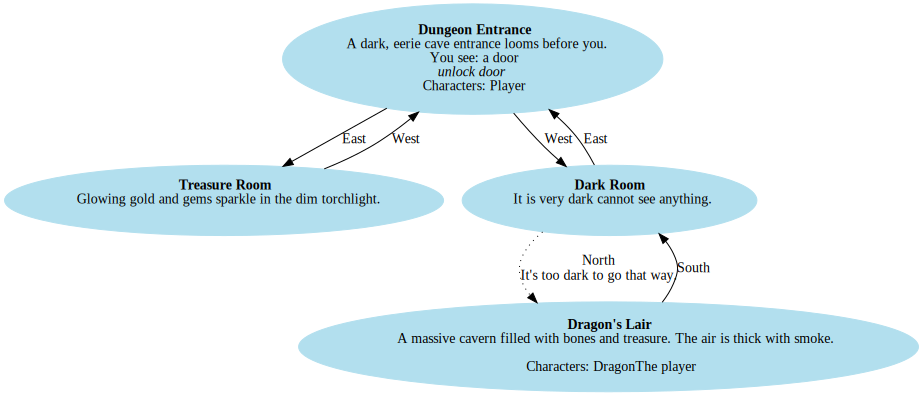

In [146]:
tempgame = games.Game(dungeon_entrance, things.Character(name="Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()

graph

# Items

In [133]:
sword = things.Item(
    "sword",
    "a rusty sword",
    "A DRAGON KILLER RUSTY SWORD.",
)
treasure_room.add_item(sword)
sword.add_command_hint("use vinegar to remove rust")
sword.set_property("has_rust", True)


key = things.Item(
    "key",
    "a shiny key",
    "A KEY TO ENTER DRAGONS LAIR.",
)
dungeon_entrance.add_item(key)


vinegar = things.Item(
    "vinegar",
    "vinegar",
    "VINEGAR TO REMOVE RUST FROM SWORD.",
)
treasure_room.add_item(vinegar)


In [134]:
door = things.Item(
    "door",
    "a door",
    "THE DOOR TO DRAGONS LAIR IS SECURELY LOCKED."
)
door.set_property("gettable", False)
door.set_property("is_locked", True)
door.add_command_hint("unlock door")
dungeon_entrance.add_item(door)

# Player

In [135]:
# Player
player = things.Character(
    name="The player",
    description="You are a simple peasant destined for greatness.",
    persona="I am on an adventure.",
)

# Player's lamp
lamp = things.Item("lamp", "a lamp", "A LAMself.")
lamp.set_property("is_lightable", True)
lamp.set_property("is_lit", False)
lamp.add_command_hint("light lamp")
player.add_to_inventory(lamp)

# NPC

In [136]:
dragon = things.Character(
    name="dragon",
    description="A fierce dragon is sleeping.",
    persona="Who woke me up from my sleep! You are going to die here",
)
dragon.set_property("character_type", "dragon")
dragon.set_property("is_alive", True)
dragon_boss_room.add_character(dragon)

# Actions

In [137]:
# Kill dragon
# add vinegar to sword (remove rust from sword)
# unlock door
class Unlock_Door(actions.Action):
    ACTION_NAME = "unlock door"
    ACTION_DESCRIPTION = "Unlock a door with a key"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.command = command
        self.character = self.parser.get_character(command)
        self.location = self.character.location
        self.key = self.character.inventory.get("key") 
        self.door = None
        if self.location:
            self.door = self.location.items.get("door")
        # for val in self.location.items.values():
        #     if val.name=="door":
        #         self.door = val
        #         break
        # HINT: take a look at text_adventure_games/actions for some examples of actions!

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a door
        * The character must be at the same location as the door
        * The door must be locked
        * The character must have the key in their inventory
        """
        # TODO - your code here
        if not self.door:
            description = "There is no door at this location."
            self.game.parser.fail(description)
            return False
        elif not self.key:
            description = "You do not have the key to unlock the door."
            self.game.parser.fail(description)
            return False
        elif not self.door.get_property("is_locked"):
            description = "The door is not locked."
            self.game.parser.fail(description)
            return False

        return True

    def apply_effects(self):
        """
        Effects:
        * Unlocks the door
        """
        # TODO - your code here
        self.character.remove_from_inventory(self.key)
        self.door.set_property("is_locked", False)
        self.game.parser.ok("You have opened the door with the key")

In [138]:
class Remove_Rust(actions.Action):
    """
    Using vinegar to remove the rust from the sword. This can be then used to slay the dragon.
    """
    ACTION_NAME = "remove rust"
    ACTION_DESCRIPTION = "remove rust off of the sword"
    ACTION_ALIASES = []

    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.command = command
        self.character: things.Character = self.parser.get_character(command)
        self.sword: things.Item = self.character.inventory.get("sword") 
        self.vinegar: things.Item = self.character.inventory.get("vinegar") 


    def check_preconditions(self) -> bool:
        """
        Preconditions
        """
        print("in precondition remove rust")
        if not self.sword:
            description = "There is no sword in the inventory."
            self.game.parser.fail(description)
            return False
        if not self.vinegar:
            description = "There is no vinegar in the inventory."
            self.game.parser.fail(description)
            return False
        
        return True

    def apply_effects(self):
        """
        Effects:
        * Removes the rust from sword
        """
        print("inside rust apply effects")
        
        self.sword.set_property("has_rust", False)
        self.game.parser.ok("Rust has been removed!")

In [139]:
class Kill_Dragon(actions.Action):
    """
    Using the dragon slayer sword, kill the dragon to complete the dungeon and save the world!
    """
    ACTION_NAME = "use sword"
    ACTION_DESCRIPTION = "Kills the dragon with the sword"
    ACTION_ALIASES = []

    def __init__(self, game, command):
        super().__init__(game)

        self.command = command
        self.character: things.Character = self.parser.get_character(command)
        self.location = self.character.location
        self.sword: things.Item = self.character.inventory.get("sword") 
        self.dragon: things.Character = None
        if self.location:
            self.dragon = self.location.characters.get("dragon")


    def check_preconditions(self) -> bool:
        """
        Preconditions:
        """
        if not self.dragon:
            description = "There is no dragon at this location."
            self.game.parser.fail(description)
            return False
        if not self.dragon.get_property("is_alive"):
            self.game.parser.fail("Dragon is already dead!!")  
            return False   
        
        return True

    def apply_effects(self):
        """
        Effects:
        * kills the dragon! You win!
        """
        # TODO - your code here
        if not self.sword:
            description = "There is no sword in the inventory. Dragon Kills you"
            self.game.parser.fail(description)
            self.game.parser.fail("GAME OVER")
            self.game.game_over = True
        elif self.sword.get_property("has_rust"):
            description = "Sword has rust. Couldn't kill the dragon! Dragon Kills you."
            self.game.parser.fail(description)
            self.game.parser.fail("GAME OVER")
            self.game.game_over = True
        else:
            self.game.parser.ok("The dragon has been killed!")
            self.dragon.set_property("is_alive", False)


# Blocks

In [140]:
class Darkness(blocks.Block):
    """
    Blocks progress in this direction unless the character has something that lights the way.
    """

    def __init__(self, location: things.Location):
        super().__init__("Darkness blocks your way", "It's too dark to go that way.")
        # TODO - your code here
        self.location = location

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The location is dark
        # * Unblocked if any character at the location is carrying a lit item 
        #   (like a lamp or candle)
        # TODO - your code here
        if self.location.get_property("is_dark"):
            for char in self.location.characters.values():
                for item in char.inventory.values():
                    if item.get_property("is_lit"):
                        return False
            return True
        return False

In [141]:
class Door_Block(blocks.Block):
    """
    Blocks progress in this direction until the character unlocks the door.
    """

    def __init__(self, location: things.Location, door: things.Item):
        super().__init__("A locked door blocks your way", "The door ahead is locked.")
        self.location = location
        self.door = door

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The door is locked
        if self.door and self.door.get_property("is_locked"):
            return True
        
        return False

In [142]:
darkness_block = Darkness(dark_room)
dark_room.add_block("north", darkness_block)

door_block = Door_Block(dungeon_entrance, door)
dungeon_entrance.add_block("east", door_block)

You are at the enterance. East there is treasure room. West there is dark room. 

North of Dark room is Dragon room.  But dark room is dark need lamp

Treasure room has sword, vinegar

entrance has key to treasure door

player has lamp (use it in dark room)

Dragon room has dragon

In [143]:
class DungeonGame(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)

    def is_won(self) -> bool:
        """ 
        Checks whether the game has been won. For Action Castle, the game is won
        once any character is sitting on the throne (has the property is_reigning).
        """
        for name, character in self.characters.items():
            if name=="dragon" and not character.get_property("is_alive"):
                msg = "The Dragon is dead! {name} has won the game!"
                self.parser.ok(msg.format(name=character.name.title()))
                return True
        return False

In [144]:

characters = [dragon]
custom_actions = [Unlock_Door, Remove_Rust, Kill_Dragon]

# The Game
game = DungeonGame(dungeon_entrance, player, characters=characters, custom_actions=custom_actions)


In [145]:
game.game_loop()

A dark, eerie cave entrance looms before you.
Exits:
East to Treasure Room
West to Dark Room

You see:
 * a shiny key
 * a door
        unlock door
Characters:
 *

The player got the key.
You have opened the door with the key
Dungeon entrance does not have an exit 'None'
It is very dark cannot see anything.
Exits:
East to Dungeon Entrance
North to Dragon's Lair




It's too dark to go that way.
A dark, eerie cave entrance looms before you.
Exits:
East to Treasure Room
West to Dark Room

You see:
 * a door
        unlock door
Characters:
 *

Dungeon entrance does not have an exit 'None'
Glowing gold and gems sparkle in the dim torchlight.
Exits:
West to Dungeon Entrance

You see:
 * a rusty sword
        use vinegar to remove rust
 * vinegar


I don't see it.
I don't see it.
The player got the vinegar.
The player got the sword.
I'm not sure what you want to do.
No action found for use vineger on sword
I'm not sure what you want to do.
in precondition remove rust
inside rust apply effect